# Task IX. Quantum Kolmogorov-Arnold Networks for High Energy Physics Analisys at the LHC

<b> Instructions</b>

Implement a <i>classical</i> Kolmogorov-Arnold Network using basis-splines or some other KAN architecture and apply it to MNIST. Show its performance on the test data.

Comment on potential ideas to extend this classical KAN architecture to a quantum KAN and sketch out the architecture in detail.

## **Table of Content**

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
1. [Introduction](#1-introduction)<br>
2. [Classical KAN on MNIST](#2-classical-kan-on-mnist) <br>
3. [Extentions Q-KANs](#3-extensions-quantum-kolmogorov-arnold-networks) <br>
4. [References](#4-references) <br>
    </div>
    <hr>
***

## 1. Introduction

This section introduces the foundational concepts that underpin our work, beginning with Hilbert’s 13th Problem, progressing through the Kolmogorov-Arnold Theorem, and culminating in the discussion of Kolmogorov-Arnold Networks (KANs).

### 1.1 Hilbert's 13th Problem

Hilbert’s 13th Problem originated from a series of 23 open problems presented by David Hilbert in 1900, which greatly influenced the direction of mathematical research in the twentieth century. Specifically, the 13th problem asks whether the solution of a general algebraic equation of degree seven can be represented as a superposition of continuous functions of two variables. Formally, Hilbert inquired whether one can express the roots of a seventh-degree polynomial, whose solution by radicals is precluded by the Abel-Ruffini theorem, in terms of functions that depend only on two variables. This problem highlights a fundamental inquiry into the nature of functional representation and the inherent complexity of multivariable functions.

### 1.2 Kolmogorov-Arnold Theorem

Building on the insights prompted by Hilbert’s question, the Kolmogorov-Arnold Theorem provided a groundbreaking result in the theory of functions. The theorem states that any continuous function $f:[0,1]^n \rightarrow \mathbb{R}$ can be represented as a finite sum of compositions of continuous functions of a single variable and addition. A typical formulation of the theorem is as follows:

\begin{equation}
    f{x_1, x_2, ..., x_n} = \sum_{q=1}^{2n+1} \phi_q
                            \left( \sum_{p=1}^{n} \psi_{pq}(x_p) \right)
\end{equation}

where $\phi_q: \mathbb{R} \rightarrow \mathbb{R}$ and $\psi_{pq}: \mathbb{R} \rightarrow \mathbb{R}$ are continuous functions. This result not only resolved Hilbert's query in a topological sense but also established a universal representation for multivariate continuous functions, thereby providing a theoretical foundation for various approximation methods in analysis and computational mathematics.

### 1.3 Kolmogorov-Arnold Networks (KANs)

Kolmogorov-Arnold Networks (KANs) are neural network architectures inspired by the Kolmogorov-Arnold Theorem. They aim to leverage the theorem's insight that any continuous function can be decomposed into a finite composition of univariate functions and addition. This approach is particularly attractive in the context of function approximation and learning, where interpretability and efficiency are crucial.

#### 1.3.1 Spline-based

Spline-based KANs utilize basis splines (B-splines) to model the univariate functions $\phi_q$ and $\psi_{pq}$ involved in the Kolmogorov-Arnold representation. B-splines are well-suited for this task due to their excellent approximation properties, smoothness, and computational efficiency. By representing the univariate functions as a linear combination of B-spline basis functions, these networks can achieve high levels of accuracy with relatively few parameters. This makes spline-based KANs particularly useful in settings where interpretability and smooth function approximation are desired.

#### 1.3.2 Shallow architectures

Shallow architectures in the context of KANs refer to network designs that do not require deep, multi-layered structures to approximate complex functions. Instead, the decomposition provided by the Kolmogorov-Arnold Theorem allows for the construction of networks with a single or few hidden layers. In such architectures, the critical non-linear transformations are performed by the univariate function approximators, while the overall function is synthesized through a simple summation. This paradigm contrasts with conventional deep networks, and it offers advantages in terms of interpretability and computational efficiency, especially when the target functions exhibit a structure that is well-captured by the theorem's decomposition.

___
___

## 2. Classical KAN on MNIST

In this section, we implement a classical Kolmogorov–Arnold Network (KAN) using a spline-based architecture. The notebook is structured as follows:

<b>2.1 Data Preparation and Visualization:</b> Load the MNIST dataset and split train into 80% for training and 20% for validation. The test set doesn't chance.

<b>2.2 KAN Model Implementation and Training:</b> Define the spline-based KAN architecture, train the model with early stopping (patience of 3 epochs on validation loss), and save the best model.

<b>2.3 Evaluation:</b> Evaluate the model using five metrics (accuracy, confusion matrix, precision, recall, and F1-score) and plot the training/validation loss curves.

In [60]:
%pip install tensorflow
%pip install tensorflow-probability

### 2.1 Data preparation and visulization

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
print("The packages were imported successfully, you can continue.")

The packages were imported successfully, you can continue.


In [62]:
# Load MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Normalize images
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape images to vectors (MNIST images are 28x28 => 784 features)
x_train_full = x_train_full.reshape((x_train_full.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Split data into, approximate, 70% training, 15% validation, 15% test
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.16, random_state=42)

print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)

Training set: (50400, 784) (50400,)
Validation set: (9600, 784) (9600,)
Test set: (10000, 784) (10000,)


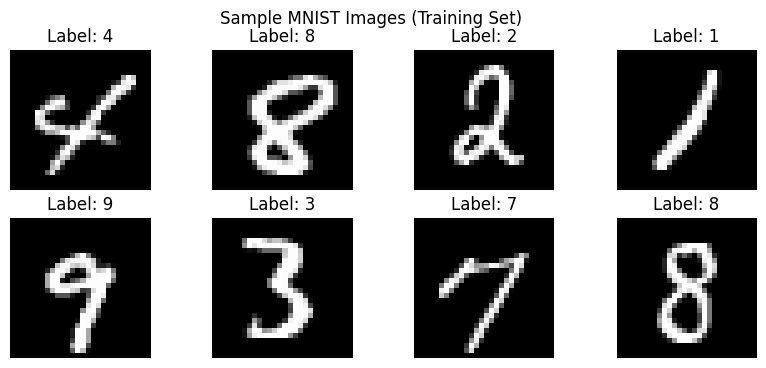

In [63]:
# Visualize some sample images from the training set
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Sample MNIST Images (Training Set)")
plt.show()

### 2.2 KAN Model implemetation and training

In this section, we define our spline-based KAN architecture. The design is inspired by the Kolmogorov–Arnold representation. The network is structured as follows:

1. **BSplineLayer ($\psi$ function):** A custom layer that applies a spline-based transformation elementwise on the input. This layer approximates a univariate function via a fixed number of trainable control points.

2. **Group Sum Layer:** The output of the $\psi$ layer is grouped and summed along feature groups. For MNIST, with 784 input features, we partition the features into 8 equal groups.

3. **BSplineLayer ($\phi$ function):** A second BSplineLayer is applied to each group sum to produce a non-linear transformation.

4. **Final Dense Layer:** The outputs are concatenated and fed to a final Dense layer with softmax activation for classification.

The training procedure uses early stopping (patience = 5 epochs) based on the validation loss.
At each epoch, training and validation accuracy and loss are printed, and the best model is saved.

In [64]:
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-probability
#!pip install tf-keras

In [65]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, callbacks # type: ignore
from os import name
print("The packages were imported successfully, you can continue.")

The packages were imported successfully, you can continue.


#### First architecture

In [66]:
# Define a custom BSplineLayer that applies a spline-based transformation using interpolation.
class BSplineLayer(layers.Layer):
    def __init__(self, num_knots=50, x_min=0.0, x_max=1.0, **kwargs):
        """
        num_knots: Number of knots (control points) for the spline.
        x_min, x_max: Range over which the spline is defined (assumes inputs are normalized).
        """
        super(BSplineLayer, self).__init__(**kwargs)
        self.num_knots = num_knots
        self.x_min = x_min
        self.x_max = x_max

    def build(self, input_shape):
        # Initialize trainable control points for the spline transformation.
        self.control_points = self.add_weight(
            shape=(self.num_knots,),
            #initializer=tf.keras.initializers.RandomUniform(minval=-1.0, maxval=1.0),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True,
            name="control_points"
        )
        super(BSplineLayer, self).build(input_shape)

    def call(self, inputs):
        # Clamp inputs to the defined range to avoid extrapolation issues.
        clamped_inputs = tf.clip_by_value(inputs, self.x_min, self.x_max)

        # Use TensorFlow Probability's interpolation function to compute the spline output.
        # This function interpolates the control points over the regular grid defined by num_knots.
        # The inputs are assumed to be in the range [x_min, x_max].
        outputs = tfp.math.interp_regular_1d_grid(
            x=inputs,
            x_ref_min=self.x_min,
            x_ref_max=self.x_max,
            y_ref=self.control_points,
            axis=-1
        )
        return outputs

    def get_config(self):
        config = super(BSplineLayer, self).get_config()
        config.update({
            "num_knots": self.num_knots,
            "x_min": self.x_min,
            "x_max": self.x_max,
        })
        return config

# Define a custom layer for grouping and summing features.
class GroupSumLayer(layers.Layer):
    def __init__(self, num_groups, **kwargs):
        """
        num_groups: Number of groups to partition the features into.
        """
        super(GroupSumLayer, self).__init__(**kwargs)
        self.num_groups = num_groups

    def call(self, inputs):
        # inputs shape: (batch, num_features)
        num_features = tf.shape(inputs)[1]
        # Calculate group size (assuming num_features is divisible by num_groups)
        group_size = num_features // self.num_groups
        # Reshape to (batch, num_groups, group_size)
        reshaped = tf.reshape(inputs[:, :self.num_groups * group_size], (-1, self.num_groups, group_size))
        # Sum along the last dimension (group_size)
        group_sum = tf.reduce_sum(reshaped, axis=-1)
        return group_sum

    def get_config(self):
        config = super(GroupSumLayer, self).get_config()
        config.update({"num_groups": self.num_groups})
        return config

# Define the full KAN model architecture.
def build_kan_model(input_dim=784, num_groups=28, num_knots=50, dropout_rate = 0.3):
    inputs = layers.Input(shape=(input_dim,))

    # \phi transformation: apply BSplineLayer elementwise.
    psi = BSplineLayer(num_knots=num_knots, x_min=0.0, x_max=1.0, name="psi_spline")(inputs)

    # Group the features into equal groups and sum them.
    grouped = GroupSumLayer(num_groups=num_groups, name="group_sum")(psi)

    # Normalize the grouped features.
    bn = layers.BatchNormalization(name="bn_group")(grouped)

    # Dropout for regularization
    dropout1 = layers.Dropout(dropout_rate, name="dropout_after_group")(grouped)

    # \phi transformation: apply BSplineLayer to each group's sum.
    phi = BSplineLayer(num_knots=num_knots, x_min=0.0, x_max=grouped.shape[-1], name="phi_spline")(grouped)

    # Flatten the output and add dense layers to improve accuracy
    flatten = layers.Flatten()(phi)
    outputs = layers.Dense(10, activation="softmax", name="output")(flatten)

    model = models.Model(inputs=inputs, outputs=outputs, name="Spline_Based_KAN")
    return model

# Build the model
model_2 = build_kan_model()
model_2.summary()

Model: "Spline_Based_KAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ psi_spline (BSplineLayer)            │ (None, 784)                 │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_sum (GroupSumLayer)            │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ phi_spline (BSplineLayer)            │ (None, 28)                  │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390 (1.52 KB)

 Trainable params: 390 (1.52 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_val_cat   = to_categorical(y_val, num_classes=10)
y_test_cat  = to_categorical(y_test, num_classes=10)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Compile the model
model_2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks: EarlyStopping and ModelCheckpoint
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("best_kan_model_noDense.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history_2 = model_2.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

Epoch 1/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1104 - loss: 2.3036
Epoch 1: val_loss improved from inf to 2.30172, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1104 - loss: 2.3036 - val_accuracy: 0.1101 - val_loss: 2.3017
Epoch 2/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1108 - loss: 2.3014
Epoch 2: val_loss improved from 2.30172 to 2.30167, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1108 - loss: 2.3014 - val_accuracy: 0.1101 - val_loss: 2.3017
Epoch 3/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1125 - loss: 2.3013
Epoch 3: val_loss did not improve from 2.30167
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1125 - loss: 2.3013 - val_accuracy: 0.1101 - val_loss: 2.3018
Epoch 4/50
780/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1755 - loss: 2.2003
Epoch 4: val_loss improved from 2.30167 to 1.01227, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1775 - loss: 2.1963 - val_accuracy: 0.6526 - val_loss: 1.0123
Epoch 5/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6713 - loss: 0.9376
Epoch 5: val_loss improved from 1.01227 to 0.86864, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6713 - loss: 0.9375 - val_accuracy: 0.6918 - val_loss: 0.8686
Epoch 6/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6909 - loss: 0.8701
Epoch 6: val_loss improved from 0.86864 to 0.85457, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6909 - loss: 0.8701 - val_accuracy: 0.6941 - val_loss: 0.8546
Epoch 7/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7022 - loss: 0.8499
Epoch 7: val_loss improved from 0.85457 to 0.85297, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7022 - loss: 0.8499 - val_accuracy: 0.6999 - val_loss: 0.8530
Epoch 8/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7016 - loss: 0.8375
Epoch 8: val_loss did not improve from 0.85297
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7016 - loss: 0.8375 - val_accuracy: 0.6830 - val_loss: 0.8878
Epoch 9/50
779/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7066 - loss: 0.8405
Epoch 9: val_loss did not improve from 0.85297
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7066 - loss: 0.8403 - val_accuracy: 0.6972 - val_loss: 0.8639
Epoch 10/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7134 - loss: 0.8239
Epoch 10: val_loss improved from 0.85297 to 0.81873, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7134 - loss: 0.8240 - val_accuracy: 0.7101 - val_loss: 0.8187
Epoch 11/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7118 - loss: 0.8182
Epoch 11: val_loss improved from 0.81873 to 0.81520, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7118 - loss: 0.8182 - val_accuracy: 0.7105 - val_loss: 0.8152
Epoch 12/50
779/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7155 - loss: 0.8176
Epoch 12: val_loss improved from 0.81520 to 0.80730, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7154 - loss: 0.8176 - val_accuracy: 0.7172 - val_loss: 0.8073
Epoch 13/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7114 - loss: 0.8224
Epoch 13: val_loss did not improve from 0.80730
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7114 - loss: 0.8224 - val_accuracy: 0.7031 - val_loss: 0.8492
Epoch 14/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7122 - loss: 0.8194
Epoch 14: val_loss did not improve from 0.80730
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7122 - loss: 0.8193 - val_accuracy: 0.7080 - val_loss: 0.8179
Epoch 15/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7217 - loss: 0.8031
Epoch 15: val_loss did not improve from 0.80730
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7217 - loss: 0.8031 - val_accuracy: 0.7054 - val_loss: 0.8396
Epoch 16/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7165 - loss: 0.8155
Epoch 16: val_loss improved from 0.80730

788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7165 - loss: 0.8155 - val_accuracy: 0.7196 - val_loss: 0.8024
Epoch 17/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7191 - loss: 0.8020
Epoch 17: val_loss improved from 0.80244 to 0.80076, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7191 - loss: 0.8021 - val_accuracy: 0.7196 - val_loss: 0.8008
Epoch 18/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7218 - loss: 0.8035
Epoch 18: val_loss did not improve from 0.80076
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7218 - loss: 0.8035 - val_accuracy: 0.7173 - val_loss: 0.8022
Epoch 19/50
777/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7180 - loss: 0.8059
Epoch 19: val_loss improved from 0.80076 to 0.79966, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7181 - loss: 0.8059 - val_accuracy: 0.7202 - val_loss: 0.7997
Epoch 20/50
777/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7209 - loss: 0.8047
Epoch 20: val_loss did not improve from 0.79966
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7208 - loss: 0.8047 - val_accuracy: 0.7204 - val_loss: 0.8009
Epoch 21/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7210 - loss: 0.8048
Epoch 21: val_loss did not improve from 0.79966
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7210 - loss: 0.8048 - val_accuracy: 0.7166 - val_loss: 0.8019
Epoch 22/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7236 - loss: 0.7999
Epoch 22: val_loss did not improve from 0.79966
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7236 - loss: 0.7999 - val_accuracy: 0.7203 - val_loss: 0.7997
Epoch 23/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7214 - loss: 0.8059
Epoch 23: val_loss improved from 0.79966

788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7214 - loss: 0.8059 - val_accuracy: 0.7231 - val_loss: 0.7976
Epoch 24/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7233 - loss: 0.8029
Epoch 24: val_loss improved from 0.79758 to 0.79620, saving model to best_kan_model_noDense.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7233 - loss: 0.8029 - val_accuracy: 0.7223 - val_loss: 0.7962
Epoch 25/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7221 - loss: 0.8018
Epoch 25: val_loss did not improve from 0.79620
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7221 - loss: 0.8018 - val_accuracy: 0.7208 - val_loss: 0.7985
Epoch 26/50
779/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7229 - loss: 0.8023
Epoch 26: val_loss did not improve from 0.79620
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7229 - loss: 0.8023 - val_accuracy: 0.7196 - val_loss: 0.8021
Epoch 27/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7216 - loss: 0.8022
Epoch 27: val_loss did not improve from 0.79620
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7217 - loss: 0.8022 - val_accuracy: 0.7217 - val_loss: 0.7962
Epoch 28/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7222 - loss: 0.8063
Epoch 28: val_loss did not improve from 

#### Hybrid model

In [68]:
# Define a custom BSplineLayer that applies a spline-based transformation using interpolation.
class BSplineLayer(layers.Layer):
    def __init__(self, num_knots=50, x_min=0.0, x_max=1.0, **kwargs):
        """
        num_knots: Number of knots (control points) for the spline.
        x_min, x_max: Range over which the spline is defined (assumes inputs are normalized).
        """
        super(BSplineLayer, self).__init__(**kwargs)
        self.num_knots = num_knots
        self.x_min = x_min
        self.x_max = x_max

    def build(self, input_shape):
        # Initialize trainable control points for the spline transformation.
        self.control_points = self.add_weight(
            shape=(self.num_knots,),
            #initializer=tf.keras.initializers.RandomUniform(minval=-1.0, maxval=1.0),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True,
            name="control_points"
        )
        super(BSplineLayer, self).build(input_shape)

    def call(self, inputs):
        # Clamp inputs to the defined range to avoid extrapolation issues.
        clamped_inputs = tf.clip_by_value(inputs, self.x_min, self.x_max)

        # Use TensorFlow Probability's interpolation function to compute the spline output.
        # This function interpolates the control points over the regular grid defined by num_knots.
        # The inputs are assumed to be in the range [x_min, x_max].
        outputs = tfp.math.interp_regular_1d_grid(
            x=inputs,
            x_ref_min=self.x_min,
            x_ref_max=self.x_max,
            y_ref=self.control_points,
            axis=-1
        )
        return outputs

    def get_config(self):
        config = super(BSplineLayer, self).get_config()
        config.update({
            "num_knots": self.num_knots,
            "x_min": self.x_min,
            "x_max": self.x_max,
        })
        return config

# Define a custom layer for grouping and summing features.
class GroupSumLayer(layers.Layer):
    def __init__(self, num_groups, **kwargs):
        """
        num_groups: Number of groups to partition the features into.
        """
        super(GroupSumLayer, self).__init__(**kwargs)
        self.num_groups = num_groups

    def call(self, inputs):
        # inputs shape: (batch, num_features)
        num_features = tf.shape(inputs)[1]
        # Calculate group size (assuming num_features is divisible by num_groups)
        group_size = num_features // self.num_groups
        # Reshape to (batch, num_groups, group_size)
        reshaped = tf.reshape(inputs[:, :self.num_groups * group_size], (-1, self.num_groups, group_size))
        # Sum along the last dimension (group_size)
        group_sum = tf.reduce_sum(reshaped, axis=-1)
        return group_sum

    def get_config(self):
        config = super(GroupSumLayer, self).get_config()
        config.update({"num_groups": self.num_groups})
        return config

# Define the full KAN model architecture.
def build_kan_model(input_dim=784, num_groups=28, num_knots=50, dropout_rate = 0.3):
    inputs = layers.Input(shape=(input_dim,))

    # \phi transformation: apply BSplineLayer elementwise.
    psi = BSplineLayer(num_knots=num_knots, x_min=0.0, x_max=1.0, name="psi_spline")(inputs)

    # Group the features into equal groups and sum them.
    grouped = GroupSumLayer(num_groups=num_groups, name="group_sum")(psi)

    # Normalize the grouped features.
    bn = layers.BatchNormalization(name="bn_group")(grouped)

    # Dropout for regularization
    dropout1 = layers.Dropout(dropout_rate, name="dropout_after_group")(grouped)

    # \phi transformation: apply BSplineLayer to each group's sum.
    phi = BSplineLayer(num_knots=num_knots, x_min=0.0, x_max=grouped.shape[-1], name="phi_spline")(grouped)

    # Apply an activation to introduce non-linearity.
    act = layers.Activation("relu", name="activation_after_phi")(phi)

    # Flatten the output and add dense layers to improve accuracy
    flatten = layers.Flatten()(phi)
    dense1 = layers.Dense(128, activation='relu', name="dense_1")(flatten)
    dropout2 = layers.Dropout(dropout_rate, name="dropout_before_dense")(dense1)
    dense2 = layers.Dense(64, activation='relu', name="dense_2")(dropout2)

    outputs = layers.Dense(10, activation="softmax", name="output")(dense2)

    model = models.Model(inputs=inputs, outputs=outputs, name="Spline_Based_KAN")
    return model

# Build the model
model = build_kan_model()
model.summary()

Model: "Spline_Based_KAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ psi_spline (BSplineLayer)            │ (None, 784)                 │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_sum (GroupSumLayer)            │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ phi_spline (BSplineLayer)            │ (None, 28)                  │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           3,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_before_dense (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,718 (49.68 KB)

 Trainable params: 12,718 (49.68 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_val_cat   = to_categorical(y_val, num_classes=10)
y_test_cat  = to_categorical(y_test, num_classes=10)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks: EarlyStopping and ModelCheckpoint
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("best_kan_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)


Epoch 1/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1122 - loss: 2.3015
Epoch 1: val_loss improved from inf to 2.30192, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1122 - loss: 2.3015 - val_accuracy: 0.1101 - val_loss: 2.3019
Epoch 2/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1139 - loss: 2.3008
Epoch 2: val_loss improved from 2.30192 to 1.14217, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1139 - loss: 2.3007 - val_accuracy: 0.5975 - val_loss: 1.1422
Epoch 3/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6759 - loss: 0.9126
Epoch 3: val_loss improved from 1.14217 to 0.61703, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6762 - loss: 0.9116 - val_accuracy: 0.7788 - val_loss: 0.6170
Epoch 4/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7709 - loss: 0.6514
Epoch 4: val_loss improved from 0.61703 to 0.55044, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7709 - loss: 0.6514 - val_accuracy: 0.8049 - val_loss: 0.5504
Epoch 5/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7904 - loss: 0.5932
Epoch 5: val_loss improved from 0.55044 to 0.50120, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7904 - loss: 0.5932 - val_accuracy: 0.8170 - val_loss: 0.5012
Epoch 6/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8079 - loss: 0.5502
Epoch 6: val_loss improved from 0.50120 to 0.47518, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8079 - loss: 0.5502 - val_accuracy: 0.8338 - val_loss: 0.4752
Epoch 7/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8166 - loss: 0.5297
Epoch 7: val_loss did not improve from 0.47518
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8166 - loss: 0.5296 - val_accuracy: 0.8274 - val_loss: 0.4888
Epoch 8/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8230 - loss: 0.5076
Epoch 8: val_loss improved from 0.47518 to 0.44669, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8230 - loss: 0.5076 - val_accuracy: 0.8396 - val_loss: 0.4467
Epoch 9/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8241 - loss: 0.4991
Epoch 9: val_loss improved from 0.44669 to 0.43625, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8242 - loss: 0.4991 - val_accuracy: 0.8450 - val_loss: 0.4363
Epoch 10/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8313 - loss: 0.4827
Epoch 10: val_loss improved from 0.43625 to 0.42611, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8313 - loss: 0.4827 - val_accuracy: 0.8468 - val_loss: 0.4261
Epoch 11/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8367 - loss: 0.4710
Epoch 11: val_loss did not improve from 0.42611
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8367 - loss: 0.4711 - val_accuracy: 0.8471 - val_loss: 0.4271
Epoch 12/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8369 - loss: 0.4656
Epoch 12: val_loss improved from 0.42611 to 0.41775, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8369 - loss: 0.4656 - val_accuracy: 0.8529 - val_loss: 0.4178
Epoch 13/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8405 - loss: 0.4585
Epoch 13: val_loss improved from 0.41775 to 0.40610, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8405 - loss: 0.4585 - val_accuracy: 0.8551 - val_loss: 0.4061
Epoch 14/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8455 - loss: 0.4452
Epoch 14: val_loss improved from 0.40610 to 0.40279, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8454 - loss: 0.4452 - val_accuracy: 0.8555 - val_loss: 0.4028
Epoch 15/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8414 - loss: 0.4461
Epoch 15: val_loss improved from 0.40279 to 0.39608, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8414 - loss: 0.4461 - val_accuracy: 0.8579 - val_loss: 0.3961
Epoch 16/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8423 - loss: 0.4452
Epoch 16: val_loss improved from 0.39608 to 0.39308, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8423 - loss: 0.4452 - val_accuracy: 0.8616 - val_loss: 0.3931
Epoch 17/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8456 - loss: 0.4367
Epoch 17: val_loss improved from 0.39308 to 0.39146, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8456 - loss: 0.4367 - val_accuracy: 0.8604 - val_loss: 0.3915
Epoch 18/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8493 - loss: 0.4278
Epoch 18: val_loss improved from 0.39146 to 0.38609, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8493 - loss: 0.4278 - val_accuracy: 0.8602 - val_loss: 0.3861
Epoch 19/50
779/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8526 - loss: 0.4221
Epoch 19: val_loss did not improve from 0.38609
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8525 - loss: 0.4222 - val_accuracy: 0.8626 - val_loss: 0.3883
Epoch 20/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8474 - loss: 0.4323
Epoch 20: val_loss improved from 0.38609 to 0.38356, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8474 - loss: 0.4323 - val_accuracy: 0.8604 - val_loss: 0.3836
Epoch 21/50
779/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8507 - loss: 0.4197
Epoch 21: val_loss improved from 0.38356 to 0.37986, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8507 - loss: 0.4197 - val_accuracy: 0.8602 - val_loss: 0.3799
Epoch 22/50
778/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8530 - loss: 0.4125
Epoch 22: val_loss did not improve from 0.37986
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8529 - loss: 0.4126 - val_accuracy: 0.8604 - val_loss: 0.3833
Epoch 23/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8522 - loss: 0.4169
Epoch 23: val_loss improved from 0.37986 to 0.37597, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8522 - loss: 0.4169 - val_accuracy: 0.8650 - val_loss: 0.3760
Epoch 24/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8536 - loss: 0.4097
Epoch 24: val_loss improved from 0.37597 to 0.37451, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8536 - loss: 0.4097 - val_accuracy: 0.8650 - val_loss: 0.3745
Epoch 25/50
781/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8538 - loss: 0.4106
Epoch 25: val_loss improved from 0.37451 to 0.37391, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8538 - loss: 0.4106 - val_accuracy: 0.8656 - val_loss: 0.3739
Epoch 26/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8555 - loss: 0.4115
Epoch 26: val_loss improved from 0.37391 to 0.37140, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8555 - loss: 0.4114 - val_accuracy: 0.8648 - val_loss: 0.3714
Epoch 27/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8549 - loss: 0.4126
Epoch 27: val_loss improved from 0.37140 to 0.37099, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8549 - loss: 0.4125 - val_accuracy: 0.8660 - val_loss: 0.3710
Epoch 28/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8566 - loss: 0.4016
Epoch 28: val_loss improved from 0.37099 to 0.36839, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8566 - loss: 0.4016 - val_accuracy: 0.8680 - val_loss: 0.3684
Epoch 29/50
782/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8588 - loss: 0.3958
Epoch 29: val_loss improved from 0.36839 to 0.36277, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8589 - loss: 0.3958 - val_accuracy: 0.8678 - val_loss: 0.3628
Epoch 30/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8569 - loss: 0.3992
Epoch 30: val_loss did not improve from 0.36277
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8570 - loss: 0.3992 - val_accuracy: 0.8698 - val_loss: 0.3628
Epoch 31/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8560 - loss: 0.3964
Epoch 31: val_loss did not improve from 0.36277
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8560 - loss: 0.3964 - val_accuracy: 0.8670 - val_loss: 0.3713
Epoch 32/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8616 - loss: 0.3909
Epoch 32: val_loss did not improve from 0.36277
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8616 - loss: 0.3909 - val_accuracy: 0.8682 - val_loss: 0.3638
Epoch 33/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8604 - loss: 0.3947
Epoch 33: val_loss improved from 0.36277

788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8604 - loss: 0.3947 - val_accuracy: 0.8709 - val_loss: 0.3561
Epoch 34/50
778/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8632 - loss: 0.3919
Epoch 34: val_loss did not improve from 0.35611
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8632 - loss: 0.3919 - val_accuracy: 0.8716 - val_loss: 0.3569
Epoch 35/50
779/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8632 - loss: 0.3823
Epoch 35: val_loss improved from 0.35611 to 0.35374, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8632 - loss: 0.3823 - val_accuracy: 0.8694 - val_loss: 0.3537
Epoch 36/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8639 - loss: 0.3809
Epoch 36: val_loss improved from 0.35374 to 0.35223, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8639 - loss: 0.3809 - val_accuracy: 0.8761 - val_loss: 0.3522
Epoch 37/50
779/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8673 - loss: 0.3711
Epoch 37: val_loss improved from 0.35223 to 0.35163, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8672 - loss: 0.3712 - val_accuracy: 0.8721 - val_loss: 0.3516
Epoch 38/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8681 - loss: 0.3706
Epoch 38: val_loss did not improve from 0.35163
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8680 - loss: 0.3707 - val_accuracy: 0.8739 - val_loss: 0.3520
Epoch 39/50
780/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8631 - loss: 0.3807
Epoch 39: val_loss improved from 0.35163 to 0.35076, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8632 - loss: 0.3807 - val_accuracy: 0.8729 - val_loss: 0.3508
Epoch 40/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8640 - loss: 0.3768
Epoch 40: val_loss improved from 0.35076 to 0.34825, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8640 - loss: 0.3768 - val_accuracy: 0.8728 - val_loss: 0.3483
Epoch 41/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8624 - loss: 0.3796
Epoch 41: val_loss improved from 0.34825 to 0.34658, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8624 - loss: 0.3796 - val_accuracy: 0.8737 - val_loss: 0.3466
Epoch 42/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8657 - loss: 0.3758
Epoch 42: val_loss did not improve from 0.34658
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8657 - loss: 0.3758 - val_accuracy: 0.8725 - val_loss: 0.3495
Epoch 43/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8665 - loss: 0.3705
Epoch 43: val_loss improved from 0.34658 to 0.34551, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8665 - loss: 0.3705 - val_accuracy: 0.8741 - val_loss: 0.3455
Epoch 44/50
783/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8660 - loss: 0.3725
Epoch 44: val_loss did not improve from 0.34551
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8660 - loss: 0.3725 - val_accuracy: 0.8748 - val_loss: 0.3507
Epoch 45/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8673 - loss: 0.3693
Epoch 45: val_loss did not improve from 0.34551
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8673 - loss: 0.3693 - val_accuracy: 0.8685 - val_loss: 0.3588
Epoch 46/50
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8720 - loss: 0.3611
Epoch 46: val_loss did not improve from 0.34551
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8720 - loss: 0.3611 - val_accuracy: 0.8740 - val_loss: 0.3490
Epoch 47/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8666 - loss: 0.3685
Epoch 47: val_loss improved from 0.34551

788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8666 - loss: 0.3685 - val_accuracy: 0.8756 - val_loss: 0.3417
Epoch 48/50
784/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8705 - loss: 0.3658
Epoch 48: val_loss did not improve from 0.34165
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8705 - loss: 0.3658 - val_accuracy: 0.8764 - val_loss: 0.3430
Epoch 49/50
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8716 - loss: 0.3562
Epoch 49: val_loss improved from 0.34165 to 0.34151, saving model to best_kan_model.h5


788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8716 - loss: 0.3562 - val_accuracy: 0.8753 - val_loss: 0.3415
Epoch 50/50
785/788 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8710 - loss: 0.3620
Epoch 50: val_loss did not improve from 0.34151
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8710 - loss: 0.3620 - val_accuracy: 0.8736 - val_loss: 0.3442
Restoring model weights from the end of the best epoch: 49.


### 2.3 Evaluation

In this section, we evaluate the performance of the trained KAN model on the test dataset.
The evaluation includes:

**Accuracy**

**Confusion Matrix:** A graphical representation of the classification results.

**Precision, Recall, and F1-Score**

**Loss Curves:** Graphs of training and validation loss across epochs.

We use scikit-learn for computing the precision, recall, F1-score, and confusion matrix.


In [70]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

#### Pure KAN

In [71]:
# Load the best model
model_2 = models.load_model("best_kan_model_noDense.h5", custom_objects={'BSplineLayer': BSplineLayer, 'GroupSumLayer': GroupSumLayer})

In [72]:
# Evaluate on test data
y_pred_prob = model_2.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test

# Compute accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.7207


In [73]:
# Compute precision, recall, and F1-score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Precision: 0.7109
Recall:    0.7130
F1-Score:  0.7080


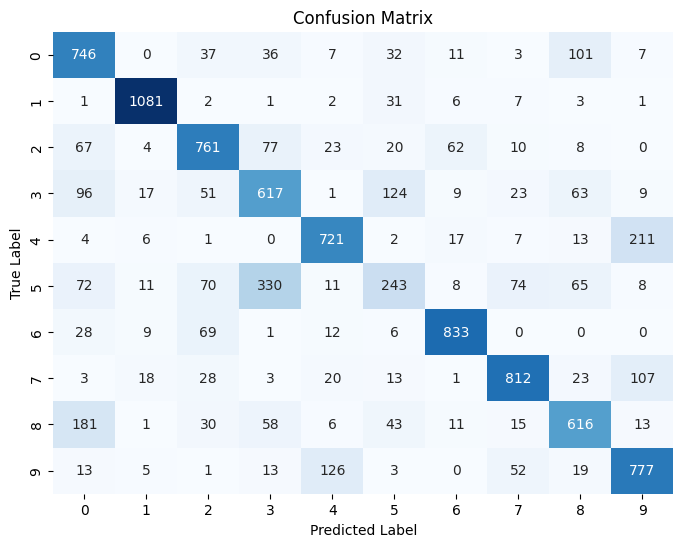

In [74]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

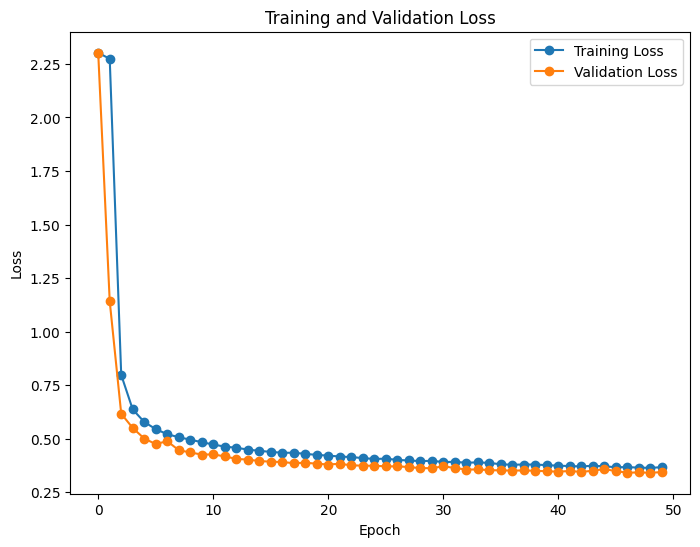

In [75]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Hybrid model

In [76]:
# Load the best model
model = models.load_model("best_kan_model.h5", custom_objects={'BSplineLayer': BSplineLayer, 'GroupSumLayer': GroupSumLayer})

In [77]:
# Evaluate on test data
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test

# Compute accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.8803


In [78]:
# Compute precision, recall, and F1-score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Precision: 0.8770
Recall:    0.8775
F1-Score:  0.8770


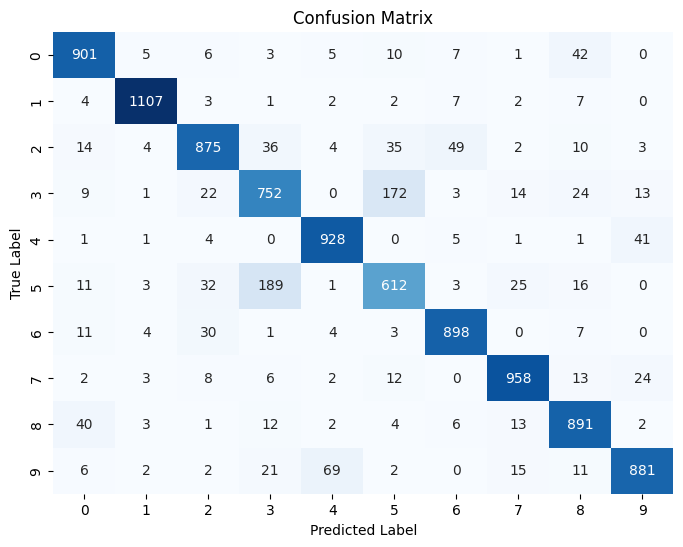

In [79]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

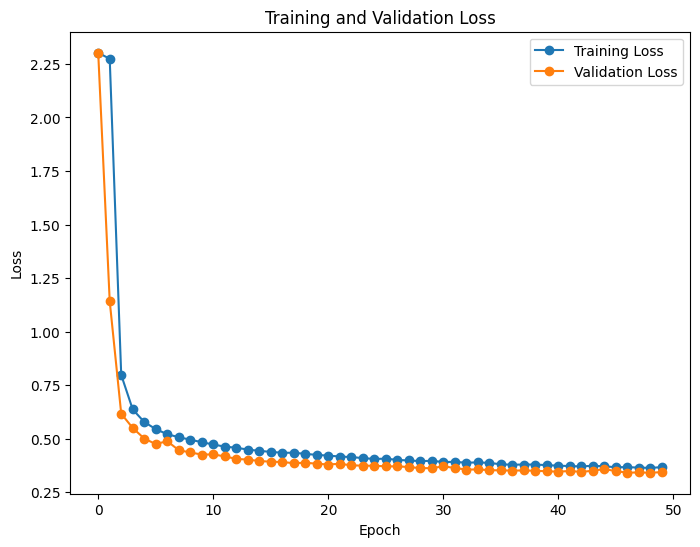

In [80]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### 2.5 Comparations

| Model      | Accuracy | Precision | Recall | F1-Score |
|------------|----------|-----------|--------|----------|
| Pure KAN   | 0.7207   | 0.7109    | 0.7130 | 0.7080   |
| Hybrid KAN | 0.8803   | 0.8770    | 0.8775 | 0.8770   |

**Pure KAN architecture**

The pure KAN achieves respectable performance given its architectural simplicity and theoretical purity. However, the lower metrics indicate that while the model is effective at capturing some underlying patterns, it might lack the representational capacity required for more complex feature interactions, which are common in image data like MNIST.

**Hybrid KAN architecture**

The incorporation of dense layers in the hybrid architecture significantly improves performance across all metrics. This enhancement is likely due to the dense layers' ability to capture complex feature interactions and perform additional non-linear mappings, complementing the base spline transformations.

Based on the metrics, the hybrid KAN architecture is clearly superior in terms of accuracy, precision, recall, and F1-score on the MNIST dataset. This suggests that while the pure KAN provides a solid baseline and interesting theoretical insights, enhancing the architecture with additional layers to capture complex interactions is beneficial for real-world tasks.

___
___

## 3. Extensions: Quantum Kolmogorov-Arnold Networks

This final section explores how classical spline-based Kolmogorov-Arnold Networks (KANs) can be extended into the quantum realm. We first discuss the limitations of classical KANs and then propose what a quantum KAN might look like, culminating in a detailed architecture sketch that leverages Pennylane for variational quantum circuit design.

### 3.1 Limitations of classical KANs

Classical KAN architectures, while elegant and interpretable, exhibit several limitations when applied to complex tasks:

* **Expressive Capacity:**
Although classical KANs approximate any continuous function via univariate spline transformations and summations, the fixed structure (e.g., grouping, BSpline layers) may limit the network’s ability to capture very high-order or intricate nonlinear interactions present in large-scale or complex datasets.

* **Scalability and Efficiency:**
The design choices (such as grouping and summing features) introduce potential information bottlenecks. As input dimensions grow, aggregating features into a small number of groups might lose critical information, thus capping performance improvements.

* **Fixed Nonlinear Transformations:**
The basis-spline approach, while flexible, relies on a fixed interpolation scheme. Adjusting the control points and number of knots can help, but the underlying model remains classical, limiting the potential benefit from novel computational paradigms.

* **Hardware Limitations:**
In a classical computer, even though these models are expressive, they often require substantial memory and computational resources when scaled up, which could be alleviated by exploring alternative computing models.

### 3.2 What could a quantum KAN look like?

A quantum Kolmogorov-Arnold Network would combine the theoretical insights of classical KANs with the unique advantages of quantum computing. The key ideas are:

* **Quantum Feature Encoding:**
Instead of relying solely on classical spline interpolation, the model could use quantum feature maps to encode classical input data into quantum states. This allows the exploitation of high-dimensional Hilbert spaces where nonlinear relationships can be captured more efficiently.

* **Variational Quantum Circuits (VQC) for Nonlinear Transformation:**
The role of the classical BSplineLayer could be replaced or augmented by variational quantum circuits. These circuits can learn complex, nonlinear transformations via parameterized quantum gates. By adjusting these parameters, the quantum circuit can effectively serve as the univariate function approximator in the KAN paradigm.

* **Hybrid Quantum-Classical Architecture:**
Given current hardware limitations (the NISQ era), a fully quantum model may not be feasible. A practical approach is to build a hybrid architecture. Here, initial feature extraction can remain classical (e.g., classical BSpline transformation or convolutional layers) while intermediate layers are replaced with quantum circuits. The final classification stage can be classical, forming a seamless pipeline.

**Motivation:**

* **Enhanced Expressiveness:** Quantum circuits can exploit superposition and entanglement, potentially leading to a richer representation of complex functions than purely classical models.

* **Parameter Efficiency:** Quantum models often achieve expressive power with fewer parameters, making them attractive for learning complex nonlinear mappings.

* **Hybrid Compatibility:** Integrating quantum layers within a classical architecture allows researchers to leverage the best of both worlds while overcoming current quantum hardware constraints.

### 3.3 Quantum KAN architecture

Below is a sketch of a hybrid quantum KAN architecture implemented using Pennylane. In this design, the classical input features are first processed by a standard classical layer. Next, the resulting representation is fed into a variational quantum circuit (VQC) which serves as the nonlinear transformation analogous to the BSplineLayer. Finally, the quantum output is measured and passed to subsequent classical layers for final prediction.

<b>Architecture Overview</b>

1. <b>Classical Preprocessing:</b>
Normalize and optionally reduce the dimensionality of the MNIST images (e.g., using PCA or a small dense layer).

2. <b>Quantum Feature Map and Variational Circuit:</b>
  * <b>Quantum Feature Map:</b> Encodes the classical data into a quantum state via parameterized rotations.

  * <b>Variational Circuit (VQC):</b> Consists of layers of parameterized single-qubit rotations and entangling gates. The circuit is designed to capture the nonlinear transformation $\phi$ from the classical KAN architecture.

  * <b>Measurement:</b> The quantum circuit is measured to produce a set of expectation values that represent the transformed features.

3. <b>Classical Postprocessing:</b>
The measured quantum features are passed to a fully connected neural network (dense layers) for classification.

<b>Architecture</b>

In [11]:
#!pip install pennylane
#!pip install tensorflow keras

In [12]:
import pennylane as qml
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
print("The packages were imported successfully, you can continue.")

The packages were imported successfully, you can continue.


In [21]:
# Quantum device
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum feature map and varational circuit
@qml.qnode(dev, interface='tf')
def quantum_feature_map(inputs, weights):
    # Encode inputs using rotation gates
    for i in range(n_qubits):
        qml.RX(np.pi * inputs[i], wires=i)

    # Apply variational circuit
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i + 1])

    # Aditional layer for more expressiveness
    for i in range(n_qubits):
        qml.RZ(weights[n_qubits + i], wires=i)

    # Mesure expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [22]:
# Wrap the quantum circuit as a keras Layer
class QuantumLayer(layers.Layer):
    def __init__(self, num_qubits, n_weights, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_qubits = n_qubits
        self.n_weights = n_weights

    def build(self, input_shape):
        # Initialize trainable weights for the quantum circuit
        self.quantum_weights = self.add_weight(
            name='quantum_weights',
            shape=(self.n_weights,),
            initializer='glorot_uniform',
            trainable=True
        )
        super(QuantumLayer, self).build(input_shape)

    def call(self, inputs):
        # Apply the quantum feature map to the inputs
        output = tf.vectorized_map(lambda x: quantum_feature_map(x, self.quantum_weights), inputs)
        output = tf.stack(output, axis=1)
        return output

# Bulding the hybrid quantum-classical KAN model
def build_hybrid_kan_model(input_dim=784, n_qubits = 8, n_weights = 2 * n_qubits):
    inputs = layers.Input(shape=(input_dim,))

    # Classical preprocessing
    classical_features = layers.Dense(n_qubits, activation='relu')(inputs)

    # Quantum feature map and variational circuit: transform classical features
    quantum_features = QuantumLayer(n_qubits, n_weights)(classical_features)

    # Classical postprocessing: fully connected layers for classification
    dense1 = layers.Dense(128, activation='relu')(quantum_features)
    dense2 = layers.Dense(64, activation='relu')(dense1)
    outputs = layers.Dense(10, activation='softmax')(dense2)

    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_Quantum_KAN")
    return model

# Build and display the model summary
quantum_kan_model = build_hybrid_kan_model()
quantum_kan_model.summary()

Model: "Hybrid_Quantum_KAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ quantum_layer_12 (QuantumLayer)      │ (None, 8)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_6 (Cast)                        │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,354 (63.88 KB)

 Trainable params: 16,354 (63.88 KB)

 Non-trainable params: 0 (0.00 B)

___
___

## 4. References

* Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljačić, M., ... & Tegmark, M. (2024). Kan: Kolmogorov-arnold networks. arXiv preprint arXiv:2404.19756.
* Schmidt-Hieber, J. (2021). The Kolmogorov–Arnold representation theorem revisited. Neural Networks, 137, 119-126. https://doi.org/10.1016/j.neunet.2021.01.020